<a href="https://colab.research.google.com/github/kimheeseo/python/blob/main/cha03_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**학습 효율화 팁**

In [14]:
# 신경망은 표현력이 매우 높은 모델이지만, 한편으로는 '훈련 된 데이터와만' 궁합이 좋아서 다른 데이터에 적용할 수 없거나
# 훈련이 불안정해서 시간이 오래 걸리는 문제가 있다.
# 이런 문제를 해결하기 위한 두 가지 대표적인 기법인 Dropout, Batch Normalization에 대해 다룬다.

import torch
from torch import nn, optim

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from torch.utils.data import TensorDataset, DataLoader
digits=load_digits()

x=digits.data
y=digits.target
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.3)

x_train=torch.tensor(x_train, dtype=torch.float32)
y_train=torch.tensor(y_train, dtype=torch.int64)

x_test=torch.tensor(x_test, dtype=torch.float32)
y_test=torch.tensor(y_test, dtype=torch.int64)

# 여러 층을 쌓아서 깊은 신경망을 구축한다.
k=100
net=nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),

    nn.Linear(k,k),
    nn.ReLU(),

    nn.Linear(k,k),
    nn.ReLU(),

    nn.Linear(k,k),
    nn.ReLU(),

    nn.Linear(k,10)
)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters())

ds=TensorDataset(x_train, y_train)
loader=DataLoader(ds, batch_size=32, shuffle=True)

In [15]:
train_losses=[]
test_losses=[]

for epoch in range(100):
  running_loss=0.0
  for i, (xx, yy) in enumerate(loader):
    y_pred=net(xx)
    loss=loss_fn(y_pred, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  train_losses.append(running_loss/i)
  y_pred=net(x_test)
  test_loss=loss_fn(y_pred, y_test)
  test_losses.append(test_loss.item())

In [16]:
for i, (xx,yy) in enumerate(loader):
  print('i값:',i,'xx값:',xx,'yy값:',yy)
  print('xx.size():',xx.size())
  print('yy.size():',yy.size())

i값: 0 xx값: tensor([[ 0.,  0.,  4.,  ...,  7.,  0.,  0.],
        [ 0.,  0., 11.,  ..., 16., 16., 12.],
        [ 0.,  0., 11.,  ...,  4.,  1.,  0.],
        ...,
        [ 0.,  6., 16.,  ..., 11.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  6.,  0.,  0.],
        [ 0.,  0., 10.,  ..., 10.,  0.,  0.]]) yy값: tensor([8, 1, 2, 3, 9, 3, 2, 3, 2, 1, 0, 2, 0, 9, 7, 1, 5, 8, 7, 1, 0, 8, 3, 1,
        2, 1, 0, 7, 8, 3, 9, 8])
xx.size(): torch.Size([32, 64])
yy.size(): torch.Size([32])
i값: 1 xx값: tensor([[ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  1., 15.,  ..., 15., 11.,  1.],
        [ 0.,  0.,  2.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  2.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 10.,  ..., 16., 16., 11.],
        [ 0.,  2., 13.,  ...,  1.,  0.,  0.]]) yy값: tensor([7, 2, 7, 0, 0, 9, 8, 1, 2, 8, 9, 8, 1, 1, 9, 3, 4, 2, 0, 7, 8, 1, 5, 1,
        6, 9, 6, 4, 7, 4, 1, 3])
xx.size(): torch.Size([32, 64])
yy.size(): torch.Size([32])
i값: 2 xx값: tensor([[ 0.,  0.,  3.,  ...,  

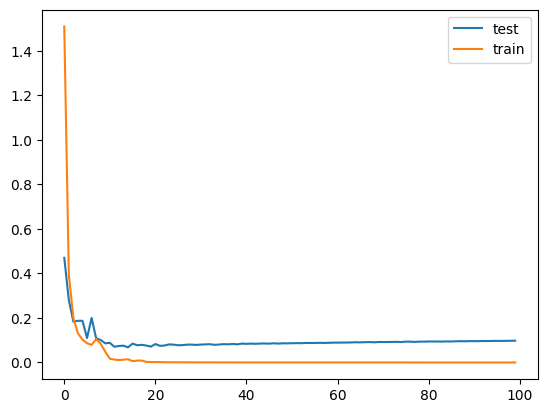

In [23]:
from matplotlib import pyplot as plt
plt.plot(test_losses,label='test')
plt.plot(train_losses,label='train')
plt.legend()
plt.show()

**정규화(regularization)**

In [27]:
# 과학습을 방지하는 것: 정규화(regularization)
# dropout: 신경망 훈련 시에만 사용하고, 예측 시에는 사용하지 않는 것이 일반적.
net=nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(k,k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k,10)
)

In [30]:
optimizer=optim.Adam(net.parameters())

train_losses=[]
test_losses=[]

for epoch in range(100):
  running_loss=0.0
  net.train()
  for i, (xx,yy) in enumerate(loader):
    y_pred=net(xx)
    loss=loss_fn(y_pred, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  train_losses.append(running_loss/i)

  # 검증 데이터의 손실함수를 계산
  net.eval()
  y_pred=net(x_test)
  test_loss=loss_fn(y_pred, y_test)
  test_losses.append(test_loss.item())

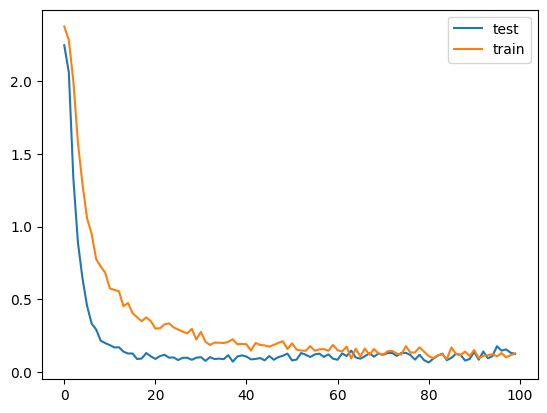

In [31]:
from matplotlib import pyplot as plt
plt.plot(test_losses,label='test')
plt.plot(train_losses,label='train')
plt.legend()
plt.show()

**Batch Normalization를 사용한 학습 가속**

In [34]:
net=nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),

    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),

    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),

    nn.Linear(k,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k,10)
)

**신경망의 모듈화**

In [35]:
# 파이토치에서 자체 신경망 계층을 만들려면 mm.Module을 상속해서 클래스를 정의하면 된다.
# 이미 특정 variable형의 x를 net(x)형식으로 사용해서 신경망에 의한 예측을 몇 번이고, 실행했었다.
# nn.Module의 __call__ 메서드는 내부에서 forward 메서드를 사용하고 있으므로, net(x) 형식이 가능했던 것이다.

class CustomLinear(nn.Module):
  def __init__(self, in_features, out_features, bias=True, p=0.5):
    super().__init__()
    self.linear=nn.Linear(in_features, out_features, bias)
    self.relu=nn.ReLU()
    self.drop=nn.Dropout(p)

  def forward(self,x):
    x=self.linear(x)
    x=self.relu(x)
    x=self.drop(x)
    return x

mlp=nn.Sequential(
    CustomLinear(64,200),
    CustomLinear(200,200),
    CustomLinear(200,200),
    nn.Linear(200,10)
)

In [36]:
# nn.Module을 상속한 클래스 이용
class MyMLP(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.ln1=CustomLinear(in_features, 200)
    self.ln2=CustomLinear(200,200)
    self.ln3=CustomLinear(200,200)
    self.ln4=CustomLinear(200, out_features)

  def forward(self,x):
    x=self.ln1(x)
    x=self.ln2(x)
    x=self.ln3(x)
    x=self.ln4(x)
    return x

mlp=MyMLP(64,10)